# Livrable 2 : Classification

|Auteur|Centre|Modification|
|---|---|---|
|Emilien Pons|Toulouse|2021/01/18|
|Nicolas Hurtevent|Toulouse|2021/01/18|
|Pierre Mazurier|Toulouse|2021/01/18|
|Pacome Chu-Lejeune|Toulouse|2021/01/18|

![logoEI_1_6.jpg](https://arras.cesi.fr/wp-content/uploads/sites/9/2019/05/Cesi_Logo_INGENIEUR_RVB-HD-500x296.jpg)

## Introduction

L'entreprise TouNum, travaillant sur la numérisation de documents, nous demande de réaliser une solution d'image captioning.

L'architecture de la solution d'image-captionning est composée de 4 modules : un module de chargement d'image, un module déterminant si l'image est une photo ou non, un troisième module de traitement basique d'image pour la rendre plus éxploitable et un dernier module de captionning.

L'entreprise souhaite automatiser la sélection de photos pour l'annotations. Nous allons donc, dans ce document, **détailler notre méthode permettant de filtrer si une image est une photo ou non**. Cette approche utilise des réseaux de neuronnes, nous allons comparer plusieurs modèles entrainés sur les mêmes données et les comparer.

Ce modèle sera utilisé par la suite sur la solution de captionning finale.

### Sommaire

- Mise en place de TensorFlow
- Théorie
    - Explication des Modèles
        - Définiton
        - Couches d'un modèle
- Pratique
    - Import du dataset
    - Modèles
        - 1. Modèle naïf
        - 2. Utilisation d'un DNN
        - 3. Utilisation de CNN
        - 4. CNN-V2 : Ajout du dropout
        - 5. CNN-V3 : Ajout de la data augmentation
        - 6. Autres méthodes pour résoudre l'overfitting
        - 7. Synthèse des résultats

## Mise en place de TensorFlow

Dans ce livrable, nous utilisons TensorFlow. C'est un outil d'apprentissage automatique développé par Google et l'un des outils les plus utilisés en IA dans le domaine du Machine Learning. Il nous offre une bibliothèque riche qui nous permettra de créer éfficacement des réseaux de neuronnes de toute architecture. C'est également l'outil que nous avons pu prendre en main lors de nos précèdents workshops.

![logo_TS](https://www.tensorflow.org/images/tf_logo_social.png)

**NB :** Si vous ne disposez pas encore de TensorFlow, l'instalation de la bibliothèque sous votre machine est la commande suivante. Vous pouvez aussi tenter de l'installer depuis la console Anaconda en suivant la [documentation](https://docs.anaconda.com/anaconda/user-guide/tasks/tensorflow/) officielle.

In [1]:
# pip install tensorflow

# Théorie

## Explication des Modèles
### Définition
Un modèle de machine learning est un algorithme entrainé à reconnaitre certains types de patterns. Un modèle est composé de différentes couches, compilé puis entrainé avec des données de teste. La phase d’entrainement pouvant être très longue, il est possible de sauvegarder le modèle et le réutiliser sans avoir à le réentraîner.

Sous TensorFlow, il est possible de créer un modèle de 2 manières : la méthode séquentielle et fonctionnelle.

#### Modèle séquentiel
Le modèle séquentiel est la manière la plus répandue pour créer des modèles. Le modèle est créé soit en passant une liste de couches à la fonction ```sequential()```.
```
const model = tf.sequential({
 layers: [
   tf.layers.dense({inputShape: [784], units: 32, activation: 'relu'}),
   tf.layers.dense({units: 10, activation: 'softmax'}),
 ]
});
```

Soit en utilisant la méthode ```add()```.
```
const model = tf.sequential();
model.add(tf.layers.dense({inputShape: [784], units: 32, activation: 'relu'}));
model.add(tf.layers.dense({units: 10, activation: 'softmax'}));
```

#### Modèle Fonctionnel
Il est possible de créer un modèle en utilisant la fonction ```tf.model``` de TensorFlow. Chaque couche est créée individuellement et connecté à l’aide de la fonction ```apply()```.
```
const input = tf.input({shape: [784]});
const dense1 = tf.layers.dense({units: 32, activation: 'relu'}).apply(input);
const dense2 = tf.layers.dense({units: 10, activation: 'softmax'}).apply(dense1);
const model = tf.model({inputs: input, outputs: dense2});
```
Cette méthode permet plus de customisation dans la création du modèle.

### Couches d’un modèle
Un modèle peut être composé de nombreuses couches différentes. Nous allons expliquer les plus fréquentes dans cette partie.

#### Dense
La couche ```Dense``` est une couche classique pour créer un réseau de neurone densément connecté, c’est-à-dire que chaque perceptron d’une couche est connecté à tous les autres perceptrons de la couche suivante.

![Densely connected Neural Network](https://stackabuse.s3.amazonaws.com/media/deep-learning-in-keras-building-a-deep-learning-model-1.png)

Avec cette fonction on peut régler des paramètres comme le nombre de perceptrons dans la couche (```units```) ou la fonction d’activation (```activation```), etc.

#### Conv2D
La couche ```Conv2D``` permet d’obtenir un couche de convolution spatiale sur une image. C’est-à-dire que chaque perceptron sera lié à un masque de convolution à un endroit donné de l’image. Nous utilisons ce type de couche pour créer des réseaux de neurones convolutifs.

![Convolution layers](https://miro.medium.com/max/3744/1*CnNorCR4Zdq7pVchdsRGyw.png)

Il est possible de régler des paramètres comme les dimensions du masque de convolution utilisé (```kernel_size```), le type de filtre utilisé (```filters```), le padding (```padding```), etc.

#### MaxPooling2D
Il est possible de créer une couche de max pooling avec ```MaxPooling2D```. Une telle couche permet de calculer la plus grande valeur pour chaque features d’une image. 

C’est en général utilisé à la suite d’une couche de convolution.

#### Flatten
La couche ```Flatten``` permet de fusionner plusieurs images en une seule dimension.

Cette couche est souvent utilisé à la suite de plusieurs couches de convolutions pour obtenir un résultat final exploitable par (par exemple) un réseau de neurones récurant.

### Compilation
Une fois instancié, sous TensorFlow, le modèle est configuré à l’aide de la méthode ```compile()```. Cela permet de définir des paramètres tels que l’optimiseur, la fonction de coût et les métriques utilisés pour évaluer le modèle.

#### Optimiseur
Le paramètre ```optimizer``` de la méthode ```compile()``` de TensorFlow permet de définir quel fonction sera utilisé lors de la modification des poids dans la phase de test du modèle. Il en existe de [nombreux]( https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), les plus répandus étant ```RMSprop```, ```SGD``` et ```Adam```.

Le plus souvent, l’optimiseur ```Adam``` est utilisé, c’est en quelque sorte un algorithme de descente de gradient stochastique avec un ```learning rate``` variable.

Plus d’informations techniques peuvent être trouvées [ici]( https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c).

#### Fonction de coût
Le paramètre ```loss``` de la méthode ```compile()``` de TensorFlow permet de définir la fonction utilisée pour calculer les coût et mesurer la performance du modèle.

Il en existe de [nombreux]( https://www.tensorflow.org/api_docs/python/tf/keras/losses), l’un des plus fréquent est le ```SparseCategoricalCrossEntropy```.

#### Métrique
Le paramètre ```metric``` de le méthode ```compile()``` de TensorFlow permet de lister les métriques que l’on souhaite évaluer par le modèle pendant les phases d’entrainement et de test.

Il en existe de [nombreux](https://www.tensorflow.org/api_docs/python/tf/keras/metrics), et dérivent, pour une bonne partie, de la matrice de confusion qui ressence les résultats des prédictions du modèle sur un jeu de données en fonction des résultats véritables, comme illustré sur le schéma suivant.

![Matrice de confusion]( https://www.researchgate.net/profile/Hazem_Wannous/publication/281162229/figure/fig59/AS:660706189918256@1534536039792/Matrice-de-confusion.png)

A partir de cette matrice, il est possible de calculer de nombreuses métriques comme, par exemple l’```accuracy```, le ```recall```, etc. Une liste complète des métriques avec les formules correspondantes se trouve [ici]( https://en.wikipedia.org/wiki/Confusion_matrix).

En général, l’```accuracy``` est une métrique utilisée, celle-ci représente le nombre de bonne prédictions (positives et négatives) sur le nombre totale de prédictions.

### Entrainement
Pendant la phase d’entrainement, l’algorithme va modifier des paramètres, comme les poids associés aux liaisons entre les perceptrons des différentes couches. Lors de cette phase, l'algorithme va tourner sur différentes images, en des boucles que l'on appelle "epoques" (ou ```epochs```).

Lors de l’entrainement, l’optimisation des paramètres se fera selon la fonction spécifiée lors de la compilation du modèle, voir partie [Compilation].

# Pratique

## Import du dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from PIL import Image
import os, os.path
import pathlib

In [2]:
img_height = 256
img_width = 256
batch_size = 32

image_h = img_height
image_w = img_width
batch_s = batch_size

Nous utilisons ici un sous-ensemble du Dataset fournit qui comprend 10000 photos et 10000 non-photos. Nous avons ce choix afin d'économiser en temps d'exécution, car utiliser les 40000+ images donnaient un temps pouvant aller jusqu'à deux heures par époque sur certaines de nos machines. 

L'arborescence est la suivante :
- Dataset 
    - Subsample
        - Photos
            - photo1.png
            - photo2.png
            - [...]
        - notPhotos
            - painting1.png
            - texte1.png
            - [...]

In [5]:
data_dir = "dataset/subsample"
data_dir = pathlib.Path(data_dir)

#load images and split train and test sets
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=  0.2,
  subset = 'training',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=  0.2,
  subset = 'validation',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


On vérifie qu'on a bien les bonnes classes

In [6]:
class_names =  train_set.class_names #a compl
print(class_names)
print(train_set)

['Photos', 'notPhotos']
<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [7]:
def plot_history(history) :
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

On affiche quelques exemples de ce que contient notre dataset

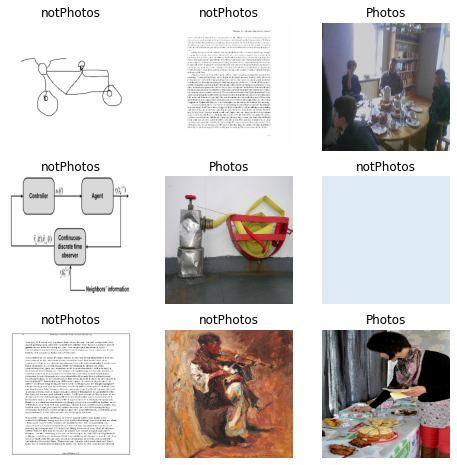

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8")) #a compl
        plt.title(class_names[labels[i]])
        plt.axis("off")

On a confirmé le contenu du dataset chargé. On peut donc maintenant le préparer pour nos modèles
On mélange donc le jeu d'entrainement pour éviter que le modèle n'apprenne à reconnaitre un ordre particulier si les données étaient triées. Il pourait par exemple remarquer sur des données triées qu'on a toujours "5 photos puis 5 tableau puis 5 photos ..." et le mélange permet d'éviter ce biais.
On ajoute également des options de caching et de prefteching pour préparer le batch suivant en avance et garder les images en mémoire. Ces options devraient grandement réduire le temps nécessaire à l'entrainement.

In [9]:
# #shuffle the train set
# #add caching and prefeching optimisations
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(100000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Modèles

## 1. Modèle naïf

    Nous allons établir un modèle de base qui soit le plus simple possible. Celui-ci va donc simplement toujours retourner la classe l pluq fréquente. Notre dataset contient 10000 images dans chaque classe. On devrait donc obtenir une accuracy avoisinant les 50%.

On utilise un modèle de scikit-learn qui apprend à retourner la valeur la plus courrante dans le jeu de donnée

In [40]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")

Plutôt que de relire les images, on réupère les valeurs présentes dans les batch du dataset créé précédement.
On se limite également à un échantillon de 100 batches de 32 images, soit 3200 images. Cet échantillonage nous offre un gain significatif de temps et le résultat final ne devrait pas beaucoup différer sur ce modèle par rapport à un entrainement fait sur les 20000 images.

In [45]:
#extract X_test and y_test back from the test set
X_test = []
y_test = []
# Only use 100 batches, or 32000 images.
# It's enough to get a good approximation of the proportion were we to use all 20000 images but saves execution time
for images, labels in test_set.take(10): 
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

In [46]:
#extract X_train and y_train back from the train set
X_train = []
y_train = []
# Only use 100 batches, or 32000 images.
# It's enough to get a good approximation of the proportion were we to use all 20000 images but saves execution time
for images, labels in train_set.take(10):
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

On entraine le modèle. Il va simplement trouver la classe la plus fréquente et la retournera toujours par la suite.

In [47]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

Enfin on calcule l'accuracy de ce modèle.

In [48]:
dummy_acc = dummy_clf.score(X_test, y_test)
print(dummy_acc)

0.48125


**Conclusion :** 

On obtient une accuracy de 50% en moyenne. On sait comme dit auparavant que notre dataset comprend 10000 images de photos et 10000 image qui ne sont pas des photos. Une légère différence pouvant aller jusqu'à plus ou moins 2% est mesurée d'un test à l'autre et est explicable par le fait qu'on entraine le modèle sur un échantillon de 3200 images parmi les 20000.


Puisque de 50% est l'accuracy obtenue par un modèle aussi simple, il faudra donc que nos modèles suivants dépassent ce seuil pour justifier leur utilisation.

## 2. Utilisation d'un DNN

Dans ce second modèle, nous utilisons un [DNN](https://en.wikipedia.org/wiki/Deep_learning#Deep_neural_networks) (deep neural network). C'est une catégories d'[ANN](https://en.wikipedia.org/wiki/Artificial_neural_network) composé de plusieurs couches. Dans notre cas, notre DNN est simple et n'est composé que de deux couches denses de 128 neurones chacunes et un dropout à 20% sur chaque couche pour éviter le surapprentissage. Plus de détails sur ces notions sera fournis dans la suite de ce document.

![DNN](images/M-DNN.png)

On créé notre modèle

In [50]:
model_dense = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [51]:
model_dense.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               25165952  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

On le compile

In [52]:
model_dense.compile(optimizer='adam', #Algorithme de la descente de gradiant
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Fonction de coût
              metrics=['accuracy'])

Et on l'entraine sur 10 époques en enregistrant ses performances à chaque époque

In [53]:
epochs=10
history =  model_dense.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
500/500 [==============================] - 54s 106ms/step - loss: 7.3699 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4890
Epoch 2/10
500/500 [==============================] - 53s 107ms/step - loss: 0.6950 - accuracy: 0.5053 - val_loss: 0.6931 - val_accuracy: 0.4895
Epoch 3/10
500/500 [==============================] - 52s 105ms/step - loss: 0.6959 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.4890
Epoch 4/10
500/500 [==============================] - 53s 107ms/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.4890
Epoch 5/10
500/500 [==============================] - 52s 104ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6934 - val_accuracy: 0.4890
Epoch 6/10
500/500 [==============================] - 54s 109ms/step - loss: 0.6929 - accuracy: 0.5089 - val_loss: 0.6929 - val_accuracy: 0.4890
Epoch 7/10
500/500 [==============================] - 52s 105ms/step - loss: 0.6927 - accuracy: 0.5040 - val_loss: 0.6926 - val_ac

On affiche sous forme de graphe la valeur de la fonction de coût et l'accuracy à chaque époque

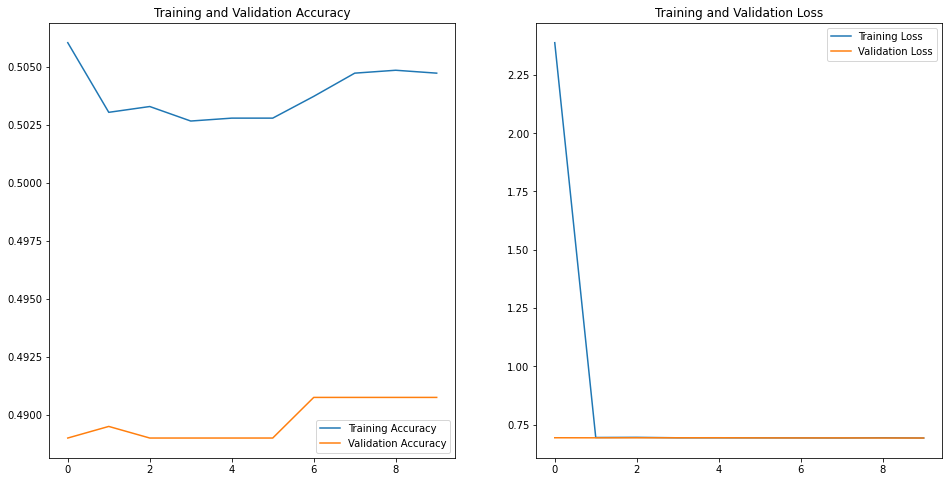

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_dnn_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion :** Bien que ce DNN soit un réseau de neuronne très simple, on voit qu'il ne permet pas encore d'obtenir des résultats significativement supérieur à notre modèle baseline. Il va donc falloir utiliser des modèles plus spécialisés pour la classification dans le traitement d'image tels que des CNN.

## 3. Utilisation d'un CNN

Dans ce troisième modèle, nous introduisons le principe des [CNN](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif). C'est un empilement de couches de perceptrons qui vont nous aider à prétraiter et déterminer des features à l'aide de deux principes : La convolution et le pooling.
- La convolution vient appliquer dynamiquement des filtres qui permettent de détecter par exemple les bords de l'image de manière optimale et de pouvoir reconnaître des formes. ![Convolution](images/convolution.gif)
- Le pooling vient condenser l'information. On perd donc en résolution mais on se concentre sur certaines features de l'image. ![pooling](images/pooling.gif)

![DNN](images/SIMPLE-CNN.png)

In [10]:
model_cnn_nopad = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [11]:
model_cnn_nopad.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model_cnn_pad_128 = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [13]:
model_cnn_pad_128.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model_cnn_pad_64 = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [15]:
model_cnn_pad_64.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model_cnn_nopad.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0

In [17]:
# test du nodpad

In [20]:
epochs=10
history =  model_cnn_nopad.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
500/500 [==============================] - 301s 602ms/step - loss: 0.4346 - accuracy: 0.7870 - val_loss: 0.3497 - val_accuracy: 0.8195
Epoch 2/10
500/500 [==============================] - 272s 544ms/step - loss: 0.3250 - accuracy: 0.8436 - val_loss: 0.3315 - val_accuracy: 0.8357
Epoch 3/10
500/500 [==============================] - 274s 547ms/step - loss: 0.2521 - accuracy: 0.8835 - val_loss: 0.4163 - val_accuracy: 0.8175
Epoch 4/10
500/500 [==============================] - 275s 549ms/step - loss: 0.1769 - accuracy: 0.9225 - val_loss: 0.3353 - val_accuracy: 0.8815
Epoch 5/10
500/500 [==============================] - 273s 545ms/step - loss: 0.1184 - accuracy: 0.9514 - val_loss: 0.3560 - val_accuracy: 0.8842
Epoch 6/10
500/500 [==============================] - 278s 556ms/step - loss: 0.0620 - accuracy: 0.9754 - val_loss: 0.4432 - val_accuracy: 0.8612
Epoch 7/10
500/500 [==============================] - 279s 558ms/step - loss: 0.0529 - accuracy: 0.9811 - val_loss: 0.4481 -

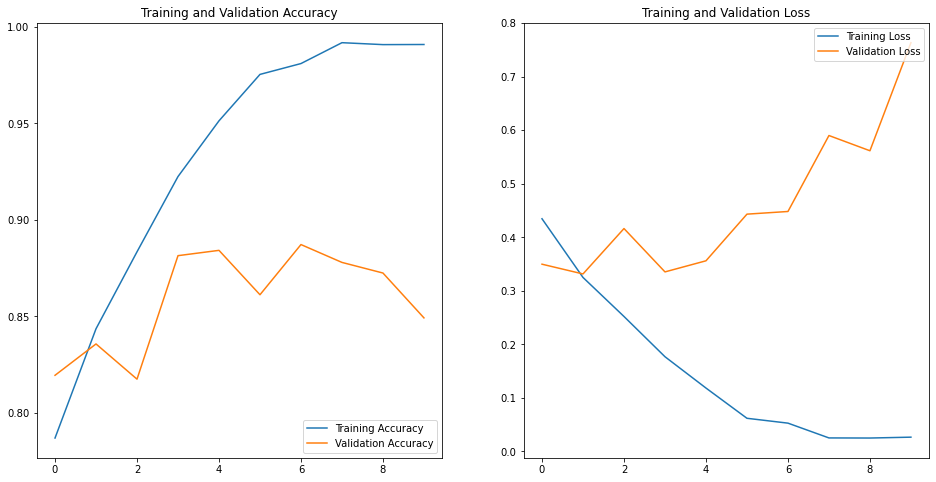

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_nopad_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion** : Le modèle fournis une très bonnes accuracy mais la différence entre le jeux d'entrainement et le jeux de test sur le graphique nous montre qu'il y a énormément d'overfitting très tôt. On voit que le modèle apprend par coeur le jeu d'entrainement et ne parviens plus à généraliser par la suite

In [ ]:
# test du pad 64

In [23]:
epochs=10
history =  model_cnn_pad_64.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
500/500 [==============================] - 288s 575ms/step - loss: 35.2297 - accuracy: 0.7073 - val_loss: 0.3971 - val_accuracy: 0.8035
Epoch 2/10
500/500 [==============================] - 302s 604ms/step - loss: 0.3461 - accuracy: 0.8398 - val_loss: 0.3737 - val_accuracy: 0.8305
Epoch 3/10
500/500 [==============================] - 298s 595ms/step - loss: 0.2765 - accuracy: 0.8742 - val_loss: 0.3798 - val_accuracy: 0.8510
Epoch 4/10
500/500 [==============================] - 305s 609ms/step - loss: 0.2080 - accuracy: 0.9070 - val_loss: 0.3978 - val_accuracy: 0.8357
Epoch 5/10
500/500 [==============================] - 311s 621ms/step - loss: 0.1539 - accuracy: 0.9306 - val_loss: 0.4371 - val_accuracy: 0.8515
Epoch 6/10
500/500 [==============================] - 289s 579ms/step - loss: 0.1131 - accuracy: 0.9522 - val_loss: 0.5232 - val_accuracy: 0.8490
Epoch 7/10
500/500 [==============================] - 276s 553ms/step - loss: 0.1006 - accuracy: 0.9562 - val_loss: 0.5672 

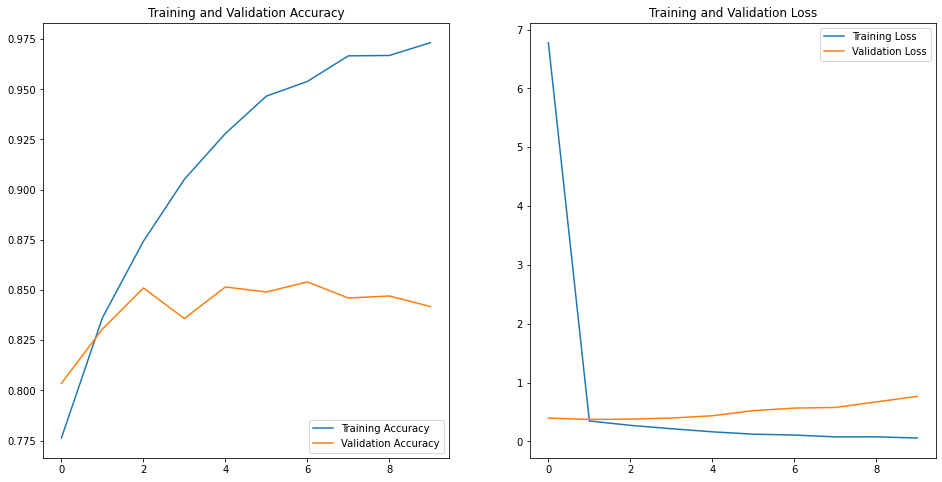

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_pad_64_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion :** Comme nous le pensions il n'y a pas de différence notable au niveau des résultats entre avec et sans le padding. Il n'y a que très peu de différence en terme de temps d'entrainement mais le gain se cumule avec les époque. Nous allons donc par la suite privilégier un modèle sans padding.

In [25]:
# test du pad 128

## ==> Pour des raisons de temps d'éxécutions, nous n'avons pas pu tester ce modèle avec les 20000images. 

Pour des raisons de temps d'exécution nous n'avons pas testés ce modèle sur le jeu de données de 20000 images.
Nous l'avions testé sur un jeu de 2000 images (ce qui est très peu) et nous obtenions une accuracy de 85.3% au lieu de 83.8% pour la version avec le dernier filtre de 64 pixels.
On avait donc légère une augmentation de l'accuracy mais au coup d'un temps d'exécution plus long et nous en avions conclus qu'il n'était pas la peine d'utiliser cette couche avec un filtre de 128 pixels en vue du rapport temps d'entrainement/accuracy. Cette remarque n'est évidement pertinente que car nous avons un temps limité pour entrainer notre modèle. Autrement il faudrait plutôt regarder le rapport entre le temps que prend une prédiction et son accuracy.

In [26]:
epochs=10
history =  model_cnn_pad_128.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
 12/500 [..............................] - ETA: 4:51 - loss: 0.6483 - accuracy: 0.5885

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_pad_128_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion :**
Bien que le CNN fournisse une très bonnes accuracy, la différence entre le jeux d'entrainement et le jeux de test sur le graphique nous montre qu'il y a énormément d'overfitting.
L'overfitting est très courrant en Machine Learning, et fort heureusement, il existe de nombreuses méthodes pour l'atténuer qui sont appellées des techniques de régularisation.

#### Régularisation

En machine learning, la régularisation est une façon de prévenir l'overfitting.
La régularisation reduit l'overfitting en ajoutant une pénalité à la fontion de coût.
En ajoutant cette pénalité, le modèle est entraîné de telle sorte qu'il n'apprend pas un ensemble de poids de caractéristiques interdépendantes. 
De telles techniques de régularisation sont "L1 regularization" (Lasso Regression) et "L2 regularization" (Rigde Regression).

La Ridge Regression ajoute la "squared magnitude" (magnitude au carré) du coefficient comme terme de pénalité à la fonction de coût.

![image.png](./images/l1.png)

Ici, si le lambda est égal à zéro, on peut imaginer que l'on récupère l'OLS (ordinary least squares). En revanche, si le lambda est très grand, il ajoutera trop de poids et entraînera un under-fitting : la manière dont le lambda est choisi est importante. Cette technique fonctionne très bien pour éviter les problèmes d'over-fitting.


Lasso Regression (Least Absolute Shrinkage and Seletion Operator) ajoute la "absolute value of magnitude" (valeur absolue de la magnitude) du coefficient comme terme de pénalité à la fonction de coût.

![image-2.png](./images/l2.png)

La principale différence entre ces tehniques est que le lasso réduit le coefficient de la caractérisques les moins importantes à zéro, supprimant ainsi certaines features en totalité. Cela fonctionne donc bien pour la features selection dans le cas où nous avons un grand nombre de features.

Les méthodes traditionnelles telles que la cross-validation, stepwise regression pour gérer l'over-fitting et la feature selection fonctionnent bien avec de petits ensemble de feature, mais L1 et L2 regression sont une excellente alternative lorsque nous avons affaire à une grand nombre de features.

D'autres méthodes utilisées existes également que nous allons voir.

## 4. CNN-V2 : ajout du dropout

Une première méthode que nous allons utiliser pour éviter l'overfit de notre CNN est le dropout.

#### Dropout

La méthode du dropout consiste à ignorer des unités (neurone) durant la phase d'entraînement de façon aléatoire, elles ne sont ni considéré durant le forward-pass ou backward-pass. Ignorer un neurone veut dire l'enlever temporairement du réseau, avec toutes ses connections entrantes et sortantes.

Le dropout a changé le concept d'apprentissage de tous les poids ensemble pour l'apprentissage d'une fraction des poids dans le réseau à chaque itération.

![image-3.png](./images/dropout.png)

On utilise le dropout pour éviter l'over-fitting. Un réseau densemment connecté occupe la majeur partie de ses paramètres et les neurones développent une co-dépendance entre eux pendant l'entraînement, ce qui limite la puissance individuelle de chaque neurone et conduit à un over-fitting des données d'entraînement.  
Plus précisément, la co-dépendance ou co-adaptation est une issue majeur des réseaux de neurones larges. Dans un tel network, si tout les poids sont entraînés ensemble, il est commun que certaines connections developpent des capacités de prédictions supérieures aux autres.  
Dans un tel scénario, comme le réseau est entraîné itérativement, ces connections plus puissantes apprennent plus pendant que les plus faibles sont ignorées. Sur plusieurs itérations, une fraction des connexions des nodes sont entraînées et le reste arrête de participer.  
En pratique, le dropout est implémenté par couche sur un réseau neuronal.  
Il peut être utilisé sur la plupart des couches, comme les couches denses, convolutionel ainsi que récurrentes comme Long Short-Term Memory.  
##### En utilisant Keras :  
La couche de dropout règle aléatoirement les unités d'entrée sur 0 avec une fréquence de <code translate="no" dir="ltr">rate</code> à chaque étape pendant la durée d'entraînement. Les entrés qui ne sont pas réglées sur 0 sont augmentées de 1/(1 - <code translate="no" dir="ltr">rate</code>) de sorte que la somme de toutes les entrées reste inchangée.

![cnn-droupout](./images/CCN-DROPOUT.png)

In [27]:
model_cnn_dropout = models.Sequential([
  layers.Conv2D(32, 3, padding='valid', activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5), #Dropout 50% of the neurons
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [28]:
model_cnn_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)       

In [29]:
model_cnn_dropout.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # fonction de coût
              metrics=['accuracy'])

In [30]:
epochs=10
history =  model_cnn_dropout.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
500/500 [==============================] - 469s 934ms/step - loss: 21.2497 - accuracy: 0.6542 - val_loss: 0.4812 - val_accuracy: 0.7837
Epoch 2/10
500/500 [==============================] - 470s 941ms/step - loss: 0.4632 - accuracy: 0.7841 - val_loss: 0.4519 - val_accuracy: 0.7820
Epoch 3/10
500/500 [==============================] - 468s 936ms/step - loss: 0.4102 - accuracy: 0.8096 - val_loss: 0.4562 - val_accuracy: 0.7910
Epoch 4/10
500/500 [==============================] - 468s 935ms/step - loss: 0.4124 - accuracy: 0.8060 - val_loss: 0.4569 - val_accuracy: 0.7933
Epoch 5/10
500/500 [==============================] - 488s 977ms/step - loss: 0.3934 - accuracy: 0.8183 - val_loss: 0.4738 - val_accuracy: 0.7970
Epoch 6/10
500/500 [==============================] - 516s 1s/step - loss: 0.3833 - accuracy: 0.8261 - val_loss: 0.4890 - val_accuracy: 0.7860
Epoch 7/10
500/500 [==============================] - 519s 1s/step - loss: 0.3641 - accuracy: 0.8346 - val_loss: 0.5190 - val_

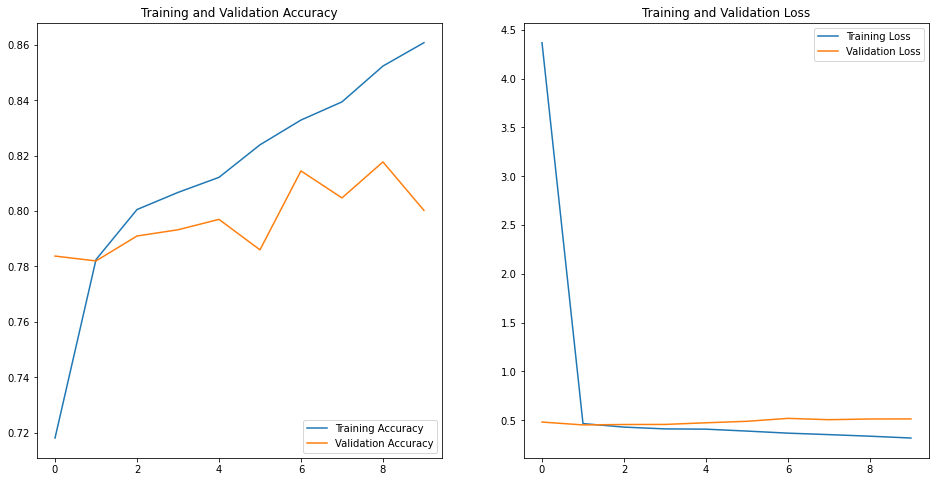

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_dropout_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion :** 
Le dropout a retardé l'overfitting et nous a permis d'atteindre une accuracy plus élevée mais on peut encore faire mieux. On pourrait laisser le modèle s'entrainer sur quelques époques de plus pour vérifier que l'accuracy sur le jeu de test n'augmente plus et ajouter une autre méthode de régularisation pour encore plus retarder l'overfitting et augmenter l'accuracy de notre modèle

## 5. CNN-V3 : Ajout de la data augmentation

#### Data augmentation

Une façon simple d'améliorer les performances de notre model est d'augmenter la quantité de données pour l'entraînement, cela simplement en récoltant plus de données.  
Dans le cas où c'est impossible, on peut augmenter la quantité de données en ajoutant des copies légèrements modifiées des données existantes ou en créant de nouvelle données synthétiques à partir de données existantes.
Lorsqu'on utilise des images, pour les modifier on peut les retourner (flip, rotation, etc), changer les couleurs, injecter du bruit, effacer des parties de l'images, etc.

L'utilisation de cette méthode force également le modèle à généraliser puisqu'il ne peut plus simplement retenir qu'une combinaison de pixels particulière à une position donnée correspond à un objet. Il est obligé de bien généraliser l'objet pour pouvoir le reconnaitre dans des conditions différentes.

![cnn-droupout](./images/CNN-DATA-AUGMENTATION.png)

In [32]:
data_augmentation = models.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(image_h, image_w, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(height_factor= 0.1)
  ]
)

In [33]:
model_cnn_dropout_augmentation = models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
  data_augmentation,
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [34]:
model_cnn_dropout_augmentation.compile(optimizer =  'adam', #A COMPLETER
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #A COMPLETER
              # loss = tf.keras.losses.SparseCategoricalCrossentropy(), #A COMPLETER
              metrics=['accuracy'])

In [35]:
model_cnn_dropout_augmentation.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 64)       

In [36]:
epochs=20
history =  model_cnn_dropout_augmentation.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/20
500/500 [==============================] - 321s 641ms/step - loss: 0.6143 - accuracy: 0.7199 - val_loss: 0.4652 - val_accuracy: 0.7765
Epoch 2/20
500/500 [==============================] - 319s 638ms/step - loss: 0.4125 - accuracy: 0.8033 - val_loss: 0.3768 - val_accuracy: 0.8223
Epoch 3/20
500/500 [==============================] - 323s 645ms/step - loss: 0.3661 - accuracy: 0.8320 - val_loss: 0.3557 - val_accuracy: 0.8493
Epoch 4/20
500/500 [==============================] - 320s 640ms/step - loss: 0.3291 - accuracy: 0.8574 - val_loss: 0.2983 - val_accuracy: 0.8770
Epoch 5/20
500/500 [==============================] - 321s 643ms/step - loss: 0.3179 - accuracy: 0.8615 - val_loss: 0.3660 - val_accuracy: 0.8415
Epoch 6/20
500/500 [==============================] - 321s 641ms/step - loss: 0.3010 - accuracy: 0.8721 - val_loss: 0.2856 - val_accuracy: 0.8823
Epoch 7/20
500/500 [==============================] - 321s 643ms/step - loss: 0.2876 - accuracy: 0.8790 - val_loss: 0.3494 -

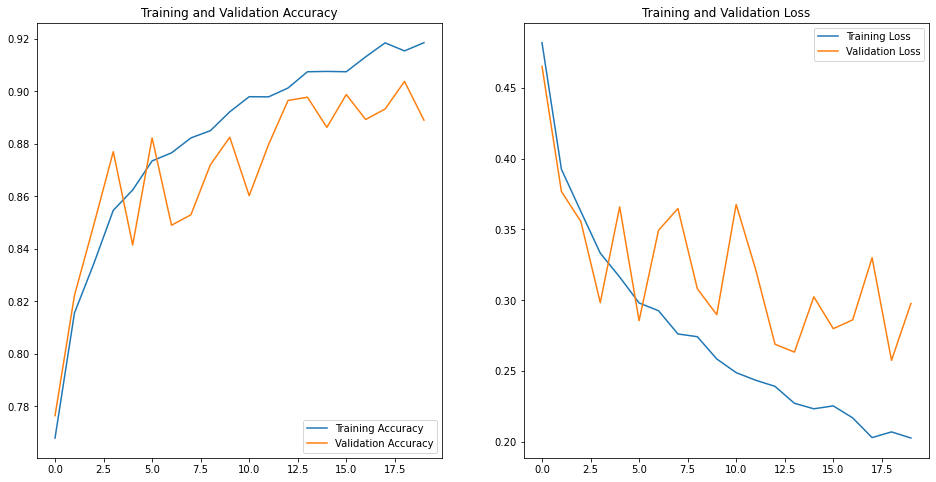

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_dropout_augmentation_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion :** 
On obtient maintenant des résultats très satisfaisants . On voit que le modèle overfit très tard et on pourrait peut être encore le laisser tourner sur quelques époques pour vérifier que l'accuracy du jeu de test n'augmente plus.
La data augmentation a donc parfaitement accomplie sont rôle.
Nous considérons que nos résultats sont maintenant satisfaisants mais si ce n'était pas la cas nous pourrions utiliser d'autres méthodes de régularisation.

## 6. Autres méthodes pour résoudre l'overfitting

Il existe d'autres méthodes que le Dropout et le Data Augmentation pour rendre nos résultats dans l'overfitting.

#### Early stopping

Une des problématiques d'entraîner les réseaux de neurones est de choisir combien de temps les entraîner.  
Pas assez entraîné, le model est under-fit et n'est pas assez performant. Trop entraîné à l'inverse, le model est over-fit sur le dataset de training et une mauvaise performance sur le set de test.

Un compromis est d'entraîner sur le dataset de training jusqu'à cec que la performance sur le dataset de validation commence à se dégrader. Cette approche simple, efficace et largement utilisé est appelé early stopping.

Pendant l'entraînement, le model est évalué sur un ensemble de données de validation après chaque epoch. Si la performance du modèle sur l'ensemble de données de validation commence à se dégrader (par exemple, la perte commence à augmenter ou l'accuracy à diminuer), alors le processus d'entraînement est arrêté.  
Le model à ce moment est alors utilisé et est connu pour avoir de bonnes performances de généralisation.

##### En utilisant Keras :
La manière d'implémenter l'early stopping avec Keras est d'utiliser les callbacks. Les callbacks étant une manière d'utiliser du code pendant que le model s'entraîne.  
Plus précisément, il est conseillé d'utiliser les callbacks 
- <code translate="no" dir="ltr">keras.callbacks.EarlyStopping</code>) qui arrête l'entraînement selon les paramètres choisi: mesure à utiliser pour vérifier la performance, ex=val_loss, durant la validation; le nombre d'epochs que l'on vérifie avant d'arrêter, puisque parfois on a juste une mauvaise itération mais la performance peut continuer à augmenter; un seuil minimum d'augmentation, si on agmente juste de 0.01 il n'y a pas vraiment d'intérer à continuer l'entraînement.
- <code translate="no" dir="ltr">keras.callbacks.ModelCheckpoint</code>) qui permet de sauvegarder le model durant l'entraînement pour garder celui avec la meilleure performance.

#### Transfer Learning

Transfer Learning est une technique de machine learning dans laquelle un modèle formé à une tâche est réutilisé pour une autre tâche connexe.

Transfer learning est lié à des problèmes tel s que l'apprentissage multitâche et le concept drift et n'est pas exclusivement un domaine d'étude pour l'apprentissage approfondi.

Il reste toutefois populaire dans le deep learning étant donné les énormes ressources requises pour former des models deep learning ou les vastes et difficiles datasets sur lesquels les models deep learning sont entraînés.

Transfer learning ne fonctionne dans le cadre du deep learning que si les model features apprises lors de la première tâche sont générales.

Cette forme de transfer learning utilisé dans le deep learning est appelée inductive transfer (transfert inductif). C'est là que la portée des modèles possibles (model bias) est réduite de manière bénéfique en utilisant un modèle adapté à une tâche différente mais connexe.

![image.png](./images/TL.png)

## 7. Synthèse des résultats

In [ ]:
# pip install tabulate

In [59]:
from tabulate import tabulate
print(tabulate([['Naive model', dummy_acc], 
                ['DNN 128', max(model_dnn_acc)],
                ['CNN no-pad 64', max(model_cnn_nopad_acc)],
                ['CNN pad 64', max(model_cnn_pad_64_acc)],
                #['CNN pad 128', max(model_cnn_pad_128_acc)],
                ['CNN no-pad 64 + dropout', max(model_cnn_dropout_acc)],
                ['CNN no-pad 64 + dropout + data augmentation', max(model_cnn_dropout_augmentation_acc)],
               ], headers=['Model', 'Max accuracy']))

Model                                          Max accuracy
-------------------------------------------  --------------
Naive model                                         0.48125
DNN 128                                             0.49075
CNN no-pad 64                                       0.88725
CNN pad 64                                          0.854
CNN no-pad 64 + dropout                             0.81775
CNN no-pad 64 + dropout + data augmentation         0.90375


**Explications des résultats :**


Comme nous l'avons vu au fur et à mesure, les performances de nos différents modèles n'ont cessées de croître. Nous utilisons à chaque fois l'accuracy la plus haute trouvée qui correspond à celle de l'époque la plus performante et reviens à faire de l'early stopping.

On obtient sans trop de surprise les meilleurs résultats avec le modèle final utilisant les techniques de régularisation mais on notera quand même le premier CNN sans régularisation qui a des performances étonnamment élevées à 88%. Il faudrait tenter de le relancer pour voir si il est tombé proche du maximal global par sérendipité  ou si il s'agit d'un véritable gain en accuracy par rapport aux autre modèles. Pour des raisons de manque de temps nous ne pouvons cependant pas faire ce test.

**Pour conclure**, nos différents tests nous ont permis de mettre en application différents types de modèles avec différents paramètres. Nous utiliserons donc la méthode no-pad 64 avec le dropout et la data augmentation pour notre futur cas d'application. L'accuracy maximale est de 90% ce qui est déjà très correct pour le nombre d'époques données.

Nous avons éffectués des recherches sur les méthodes les plus utilisés parmis la communauté de Data Scientist sur internet, pour comparer avec nos expérimentations. Voici ce que nous avons trouvé :


**Méthodes Existantes**


Le problème de classification binaire n’est pas récent. Dès 2009 des approches utilisant divers réseaux de neurones artificiels avaient déjà de bonnes performances. En effet, [ce papier]( https://researchrepository.murdoch.edu.au/id/eprint/1398/1/Comparing_the_performance.pdf) compare les performances de différents réseaux de neurones artificiels, utilisant des techniques telles que la back-propagation, radial-basis-function, general-regression, et d’autres, sur le jeu de données UCI pour résoudre des problèmes de classification binaire. 
Les performances de tels algorithmes altèrent entre 75% et 93% (environ) de précision.

Des algorithmes efficaces mais très complexes tels que VGGNet, ResNet, InceptionV3, et bien d’autres arrivent à avoir atteindre une précision de 95% sur le jeu de données ImageNet. [Cet article]( https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96) explique les architectures de ces différents algorithmes et compare les résultats. Les architectures ont un nombre de couches, convolutives en générale, variant entre une dizaine à plus de vingt.

Aujourd’hui, de tels modèles restent très demandant en ressources, surtout lors de la phase d’entrainement. Pour diminuer le temps de calcul, des algorithmes utilisant des réseaux de neurones convolutifs binaires (comme XNOR-Net) sont utilisés comme décrit dans [cet article]( https://arxiv.org/pdf/1603.05279.pdf?source=post_page---------------------------). 
Similairement aux algorithmes décrit dans le paragraphe précédent, de tels réseaux de neurones sont composés de nombreuses couches de convolution. Cette technique est récente, elle permet de réduire drastiquement le temps de calcul des convolutions mais résulte en une baisse des performances.

Notre architecture, composée de seulement 3 couches convolutives, se rapproche des algorithmes décrits dans les deux paragraphes précédents. Bien qu’étant plus simple, nous atteignions une précision d’environ 90% et la taille de notre jeu de donnée ainsi que notre temps d'exécutions sont probablement très humbles comparés à ceux de ces modèles. Nous estimons donc que le modèle final obtenu atteint un bon compromis en terme de performance et d'utilisation des ressources.